In [0]:
# 下載資料檔案
!wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id=1NmNwMDskZtb3b8BSZrHSjJnQ6bj8RYUK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!wget --load-cookies cookies.txt -O final.zip 'https://docs.google.com/uc?export=download&id=1NmNwMDskZtb3b8BSZrHSjJnQ6bj8RYUK&confirm='$(cat confirm.txt)

In [0]:
#解壓縮
!unzip -o final.zip
!unzip -o data.zip

In [0]:
from os import listdir,makedirs,path
import random
from matplotlib import pyplot
from matplotlib.image import imread
from shutil import copyfile

In [0]:
image_size = 224

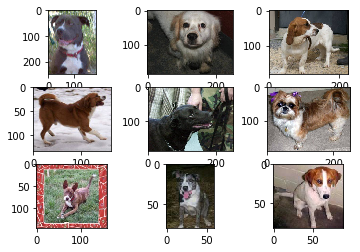

In [3]:
#預覽一下狗的照片
# plot dog photos from the dogs vs cats dataset


# define location of dataset
folder = 'kaggle_dogcat/train/dogs/'
files = listdir(folder)
fcnt = len(files)

# plot few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    imgidx = random.randint(0, fcnt)
    filename = folder + files[imgidx]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

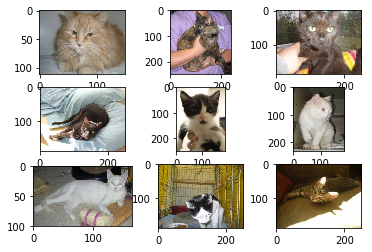

In [4]:
#預覽一下貓的照片
# define location of dataset


folder = 'kaggle_dogcat/train/cats/'
files = listdir(folder)
fcnt = len(files)

# plot few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    imgidx = random.randint(0, fcnt)
    filename = folder + files[imgidx]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

In [5]:
# 標準化影像圖片	為 200x200
# load dogs vs cats dataset, reshape and save to a new file

from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# define location of dataset
# 結合狗與貓圖片的完整路徑檔案清單
folder = 'kaggle_dogcat/train/dogs/'
files = [ folder+x for x in listdir(folder)]
folder = 'kaggle_dogcat/train/cats/'
files.extend([ folder+x for x in listdir(folder)])
print('total files: ', len(files))


photos, labels = list(), list()

# enumerate files in the directory
for file in files:
    # determine class #分類
    output = 0.0
    if file.startswith('cat'):
      output = 1.0
    # load image
    photo = load_img(file, target_size=(image_size, image_size))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)

# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)

# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

Using TensorFlow backend.


total files:  4000
(4000, 224, 224, 3) (4000,)


In [0]:
# 之後若有需要重複使用這些資料，可以利用下列方式讀取
'''
# load and confirm the shape
from numpy import load
photos = load('dogs_vs_cats_photos.npy')
labels = load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)
'''

In [0]:
# 建立資料結果目錄
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [0]:
# 區分測試資料與訓練資料，並將檔案複製過去
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
for file in files:
    src = file
    fname = path.basename(file)
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'test/'
    
    if fname.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + fname
        copyfile(src, dst)
    elif fname.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + fname
        copyfile(src, dst)


In [0]:
import sys
from matplotlib import pyplot
import keras
from keras.layers import Conv2D, SeparableConv2D, Input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
#from keras import optimizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [0]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
from keras.applications.vgg16 import VGG16

def vgg16_model():
    # load model
    model = VGG16(include_top=False, input_shape=(image_size, image_size, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
      layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
from keras.applications.vgg19 import VGG19

def vgg19_model():
    # load model
    model = VGG19(include_top=False, input_shape=(image_size, image_size, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
      layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    class2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(class1)
    output = Dense(1, activation='sigmoid')(class2)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [0]:

# run the test harness for evaluating a model
def run_test_harness(use_model):
    # define model
    model = use_model
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
      class_mode='binary', batch_size=64, target_size=(image_size, image_size))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
      class_mode='binary', batch_size=64, target_size=(image_size, image_size))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
      validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    
    print('Accu > %.3f' % (acc * 100.0))

    return model


In [11]:
# 取得測試圖片資料

folder = 'kaggle_dogcat/test/'
testfiles = [ folder+x for x in listdir(folder)]
testfiles.sort()

testphotos = list()
for file in testfiles:
    # load image
    photo = load_img(file, target_size=(image_size, image_size))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    testphotos.append(photo)

# convert to a numpy arrays
testphotos = asarray(testphotos)    
print(testphotos.shape)

(400, 224, 224, 3)


In [0]:
from datetime import datetime

# 將預測結果輸出為 CSV 檔案
def Predict2Csv(predictions, testfiles):
    now = datetime.now() # current date and time
    csvfilename = 'submission' + now.strftime("%Y%m%dT%H%M%S") + ".csv"
    print('Output to file:',csvfilename)
    with open(csvfilename,'w') as f:
        f.write('ID,Predicted\n')
        for index in range(len(testfiles)):
            img_id =path.basename(testfiles[index]).split(".")[0]
            prob = (predictions[index,0])
            #print("index: {}, img_id: {}, prob:{}".format(index,img_id, prob))
            f.write("{},{}\n".format(img_id, prob))
    print('Done.')

In [23]:
model1 = run_test_harness(vgg16_model())

# save model
# 將模型存下來，方便日後使用
#model1.save('model1_vgg16.h5')

Found 2986 images belonging to 2 classes.
Found 1014 images belonging to 2 classes.
Accu > 90.434


In [27]:
# 產生分類/預測結果
predictions1 = model1.predict(testphotos, batch_size=32, verbose=1)

400/400 [==============================] - 2s 6ms/step


In [42]:
Predict2Csv(predictions1,testfiles)

Output to file: submission20190813T135743.csv
Done.


In [25]:
model2 = run_test_harness(define_model())

# save model
# 將模型存下來，方便日後使用
#model2.save('model2_cnn.h5')

Found 2986 images belonging to 2 classes.
Found 1014 images belonging to 2 classes.
Accu > 75.345


In [28]:
predictions2 = model2.predict(testphotos, batch_size=32, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [43]:
Predict2Csv(predictions2,testfiles)

Output to file: submission20190813T135747.csv
Done.


In [50]:
model3 = run_test_harness(vgg19_model())

# save model
# 將模型存下來，方便日後使用
#model2.save('model3_vgg19.h5')

Found 2986 images belonging to 2 classes.
Found 1014 images belonging to 2 classes.
Accu > 86.884


In [48]:
predictions3 = model3.predict(testphotos, batch_size=32, verbose=1)

Predict2Csv(predictions3,testfiles)

400/400 [==============================] - 2s 6ms/step
Output to file: submission20190813T142813.csv
Done.
